# Step 01: Import Spark Session and initialize Spark

In [2]:
# Step 01: Import Spark Session and initialize Spark
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# If we want Spark to run locally with 'k' worker threads, we can specify as `local[k]`.
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[4]", appName="assignment2")
spark = SparkSession(sparkContext=sc)

In [3]:
from pyspark.sql.functions import *

# Step 02: Load the dataset and print the schema and total number of entries

In [4]:
#Step 02: Load the dataset and print the schema and total number of entries
WA_df = spark.read.csv('weatherAUS.csv', header=True)
WA_df.count() # counting the number of the records 
print (f"Number of entry in the dataset is:{WA_df.count()}")
print (f"Number of columns: {(len(WA_df.columns))}")
#WA_df.describe().show()

Number of entry in the dataset is:142193
Number of columns: 23


# Step 03: Delete columns from the dataset

In [5]:
# Step 03: Delete columns from the dataset
# Date,Location, Evaporation, Sunshine, Cloud9am, Cloud3pm, Temp9am, Temp3pm
WA_df_drop = WA_df.drop('Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm')
#WA_df_drop.printSchema()
print(f"Number of columns after deleting unnecessary columns: {(len(WA_df_drop.columns))}")

Number of columns after deleting unnecessary columns: 15


# Step 04: Print the number of missing data (NA) in each column

In [6]:
# Step 04: Print the number of missing data (NA) in each column
from pyspark.sql.functions import col,sum
WA_df_drop.select(*(sum(col(c).isin('NA').cast("int")).alias(c) for c in WA_df_drop.columns)).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



# Step 05: Fill the missing data with average value and maximum occurrence value.

In [7]:
# Step 05: Fill the missing data with average value and maximum occurrence value.
# 1: identify columns with numeric value 
# 2: calculate avg and replace null with avg 
# 3: idenfify columns with non-numeric values
# 4: find the most frequent item and replace with mfi 

In [8]:
# 1: examine which columns are numeric and not 
#WA_df_drop.show(1)

In [9]:
from pyspark.sql.functions import countDistinct, avg, stddev, min, max, sum, count
from pyspark.sql.functions import when, lit
import numpy as np

In [10]:
# 3: replace null with avg 
WA_df_step5a = WA_df_drop\
.withColumn('MinTemp', when(WA_df_drop.MinTemp=='NA', WA_df_drop.agg(avg('MinTemp')).collect()[0][0]).otherwise(WA_df_drop.MinTemp))\
.withColumn('MaxTemp', when(WA_df_drop.MaxTemp=='NA', WA_df_drop.agg(avg('MaxTemp')).collect()[0][0]).otherwise(WA_df_drop.MaxTemp))\
.withColumn('Rainfall', when(WA_df_drop.Rainfall=='NA', WA_df_drop.agg(avg('Rainfall')).collect()[0][0]).otherwise(WA_df_drop.Rainfall))\
.withColumn('WindGustSpeed', when(WA_df_drop.WindGustSpeed=='NA', WA_df_drop.agg(avg('WindGustSpeed')).collect()[0][0]).otherwise(WA_df_drop.WindGustSpeed))\
.withColumn('WindSpeed9am', when(WA_df_drop.WindSpeed9am=='NA', WA_df_drop.agg(avg('WindSpeed9am')).collect()[0][0]).otherwise(WA_df_drop.WindSpeed9am))\
.withColumn('WindSpeed3pm', when(WA_df_drop.WindSpeed3pm=='NA', WA_df_drop.agg(avg('WindSpeed3pm')).collect()[0][0]).otherwise(WA_df_drop.WindSpeed3pm))\
.withColumn('Humidity9am', when(WA_df_drop.Humidity9am=='NA', WA_df_drop.agg(avg('Humidity9am')).collect()[0][0]).otherwise(WA_df_drop.Humidity9am))\
.withColumn('Humidity3pm', when(WA_df_drop.Humidity3pm=='NA', WA_df_drop.agg(avg('Humidity3pm')).collect()[0][0]).otherwise(WA_df_drop.Humidity3pm))\
.withColumn('Pressure9am', when(WA_df_drop.Pressure9am=='NA', WA_df_drop.agg(avg('Pressure9am')).collect()[0][0]).otherwise(WA_df_drop.Pressure9am))\
.withColumn('Pressure3pm', when(WA_df_drop.Pressure3pm=='NA', WA_df_drop.agg(avg('Pressure3pm')).collect()[0][0]).otherwise(WA_df_drop.Pressure3pm))

#WA_df_step5a.show()

In [11]:
def get_mode(schema):
    
    def take_second(key):
        return key[1]
    
    column = WA_df_step5a.groupby(WA_df_step5a[schema]).count().collect()
    column.sort(key=take_second, reverse=True)
    mode = column[0]
    print(mode)
    return mode[0]

In [12]:
# 4: find the most frequent item and replace with mfi 
WA_df_step5b_new = WA_df_step5a\
.withColumn('WindGustDir',when(WA_df_step5a.WindGustDir=='NA', get_mode('WindGustDir')).otherwise(WA_df_step5a.WindGustDir))\
.withColumn('WindDir9am',when(WA_df_step5a.WindDir9am=='NA', get_mode('WindDir9am')).otherwise(WA_df_step5a.WindDir9am))\
.withColumn('WindDir3pm',when(WA_df_step5a.WindDir3pm=='NA', get_mode('WindDir3pm')).otherwise(WA_df_step5a.WindDir3pm))\
.withColumn('RainToday',when(WA_df_step5a.RainToday=='NA', get_mode('RainToday')).otherwise(WA_df_step5a.RainToday))\
.withColumn('RainTomorrow',when(WA_df_step5a.RainTomorrow=='NA', get_mode('RainTomorrow')).otherwise(WA_df_step5a.RainTomorrow))
#WA_df_step5b_new.show()

Row(WindGustDir='W', count=9780)
Row(WindDir9am='N', count=11393)
Row(WindDir3pm='SE', count=10663)
Row(RainToday='No', count=109332)
Row(RainTomorrow='No', count=110316)


# Step 06: Data transformation

In [13]:
#1 
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import DoubleType

In [14]:
#WA_df_step5b_new.printSchema()

In [15]:
#2: split the documents into numeric and non-numeric dataframe and transform seperately 
WA_df_string_trans = WA_df_step5b_new.select('RainToday','RainTomorrow','WindGustDir','WindDir9am','WindDir3pm')
#WA_df_string_trans.printSchema()
WA_df_number_trans = WA_df_step5b_new.drop('RainToday','RainTomorrow','WindGustDir','WindDir9am','WindDir3pm')
#WA_df_number_trans.printSchema()

In [16]:
#3: transform non-numeric string into double 
Indexer = [StringIndexer(inputCol=column,outputCol = column+"_index").fit(WA_df_string_trans)\
           for column in list(set(WA_df_string_trans.columns))]
pipeline = Pipeline(stages = Indexer)
trail3 = pipeline.fit(WA_df_string_trans).transform(WA_df_string_trans)
#4: drop string type columns
trail4 = trail3.drop('RainToday','RainTomorrow','WindGustDir','WindDir9am','WindDir3pm')
#trail4.printSchema()
#5: rename the columns 
WA_df_2 = trail4.withColumnRenamed('WindGustDir_index','WindGustDir')\
.withColumnRenamed('RainTomorrow_index','RainTomorrow')\
.withColumnRenamed('WindDir9am_index','WindDir9am')\
.withColumnRenamed('WindDir3pm_index','WindDir3pm')\
.withColumnRenamed('RainToday_index','RainToday')
#WA_df_2.printSchema()
WA_df_2.show(5)

+-----------+---------+----------+----------+------------+
|WindGustDir|RainToday|WindDir3pm|WindDir9am|RainTomorrow|
+-----------+---------+----------+----------+------------+
|        0.0|      0.0|       7.0|       6.0|         0.0|
|        9.0|      0.0|       3.0|       9.0|         0.0|
|        6.0|      0.0|       3.0|       6.0|         0.0|
|       13.0|      0.0|      10.0|       1.0|         0.0|
|        0.0|      0.0|       8.0|      10.0|         0.0|
+-----------+---------+----------+----------+------------+
only showing top 5 rows



In [17]:
#6: transform numeric string into double 
WA_df_1 = WA_df_number_trans.withColumn('MinTemp', WA_df_number_trans['MinTemp'].cast('double'))\
.withColumn('MaxTemp', WA_df_number_trans['MaxTemp'].cast('double'))\
.withColumn('Rainfall', WA_df_number_trans['Rainfall'].cast('double'))\
.withColumn('WindGustSpeed', WA_df_number_trans['WindGustSpeed'].cast('double'))\
.withColumn('WindSpeed9am', WA_df_number_trans['WindSpeed9am'].cast('double'))\
.withColumn('WindSpeed3pm', WA_df_number_trans['WindSpeed3pm'].cast('double'))\
.withColumn('Humidity9am', WA_df_number_trans['Humidity9am'].cast('double'))\
.withColumn('Humidity3pm', WA_df_number_trans['Humidity3pm'].cast('double'))\
.withColumn('Pressure9am', WA_df_number_trans['Pressure9am'].cast('double'))\
.withColumn('Pressure3pm', WA_df_number_trans['Pressure3pm'].cast('double'))
WA_df_1.show(5)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|
|   12.9|   25.7|     0.0|         46.0|        19.0|        26.0|       38.0|       30.0|     1007.6|     1008.7|
|    9.2|   28.0|     0.0|         24.0|        11.0|         9.0|       45.0|       16.0|     1017.6|     1012.8|
|   17.5|   32.3|     1.0|         41.0|         7.0|        20.0|       82.0|       33.0|     1010.8|     1006.0|
+-------+-------+--------+-------------+------------+------------+-----------+--

In [18]:
#7: merging two dataframe after converting to double 
#8: add column with same value for join purpose 
import pyspark.sql.functions as com
df11=WA_df_1.withColumn('raw_index', com.monotonically_increasing_id())
df22=WA_df_2.withColumn('raw_index', com.monotonically_increasing_id())
df13 = df11.join(df22,['raw_index'])
#9: once is it merged, drop the index column 
WA_df_step_6 = df13.drop('raw_index')
#10: document ready for step 7 
#WA_df_step_6.printSchema()
WA_df_step_6.show(5)

+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+---------+----------+----------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustSpeed|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|WindGustDir|RainToday|WindDir3pm|WindDir9am|RainTomorrow|
+-------+-------+--------+-------------+------------+------------+-----------+-----------+-----------+-----------+-----------+---------+----------+----------+------------+
|   13.4|   22.9|     0.6|         44.0|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|        0.0|      0.0|       7.0|       6.0|         0.0|
|    7.4|   25.1|     0.0|         44.0|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|        9.0|      0.0|       3.0|       9.0|         0.0|
|   12.9|   25.7|     0.0|         46.0|        19.0|        26.0|       38.0|       30.0|     1007.6|     1008.7|        6.0|      0.0|    

# Step 07: Create the feature vector and divide the dataset

In [19]:
# Step 07: Create the feature vector and divide the dataset
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# excluding RainTomorrow 
assembler = VectorAssembler(inputCols=['MinTemp',\
 'MaxTemp',\
 'Rainfall',\
 'WindGustSpeed',\
 'WindSpeed9am',\
 'WindSpeed3pm',\
 'Humidity9am',\
 'Humidity3pm',\
 'Pressure9am',\
 'Pressure3pm',\
 'WindGustDir',\
 'WindDir9am',\
 'WindDir3pm',\
 'RainToday'],outputCol='features')
output = assembler.transform(WA_df_step_6)
#output.columns
WA_df_step_7 = output.select('features','RainTomorrow')
WA_df_step_7 = WA_df_step_7.withColumnRenamed('RainTomorrow','label')
WA_df_step_7.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[13.4,22.9,0.6,44...|  0.0|
|[7.4,25.1,0.0,44....|  0.0|
|[12.9,25.7,0.0,46...|  0.0|
|[9.2,28.0,0.0,24....|  0.0|
|[17.5,32.3,1.0,41...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [20]:
train_data,test_data=WA_df_step_7.randomSplit([0.7,0.3])
print(f'training data:{train_data.count()}, testing data:{test_data.count()}')

training data:99473, testing data:42720


# Step 08: Apply machine learning classification algorithms on the dataset and 

In [21]:
prediction_list = list()

In [22]:
# LogisticRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
lr = LogisticRegression()
lr_result =lr.fit(train_data)
lr_trans = lr_result.transform(test_data)
prediction_list.append(lr_trans)
rain_evaluation = MulticlassClassificationEvaluator()
lr_predict = rain_evaluation.evaluate(lr_trans)
#lr_final_prediction = rain_evaluation.evaluate(lr_predict.predictions)
print(f"Prediction using logistic regression has good accuracy of: {lr_predict}")

Prediction using logistic regression has good accuracy of: 0.818665968343389


In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier 
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier

In [24]:
# DecisionTreeClassifier
DT = DecisionTreeClassifier()
# RandomForestClassifier
RF = RandomForestClassifier() # number of tree = defaul 
# GBTClassifier  
GBT = GBTClassifier()

In [25]:
DT_model = DT.fit(train_data)
RF_model = RF.fit(train_data)
GBT_model = GBT.fit(train_data)

In [26]:
DT_prediction = DT_model.transform(test_data)
prediction_list.append(DT_prediction)
RF_prediction = RF_model.transform(test_data)
prediction_list.append(RF_prediction)
GBT_prediction = GBT_model.transform(test_data)
prediction_list.append(GBT_prediction)

In [27]:
final_prediction = MulticlassClassificationEvaluator(metricName = 'accuracy')

In [28]:
DT_final_prediction=final_prediction.evaluate(DT_prediction)
print(f"decision tree provides good prediction of:{DT_final_prediction}")

decision tree provides good prediction of:0.8318586142322097


In [29]:
RF_final_prediction=final_prediction.evaluate(RF_prediction)
print(f"random forest provides good prediction of:{RF_final_prediction}")

random forest provides good prediction of:0.8311563670411986


In [30]:
GBT_final_prediction=final_prediction.evaluate(GBT_prediction)
print(f" GBT provides good prediction of:{GBT_final_prediction}")

 GBT provides good prediction of:0.8397940074906367


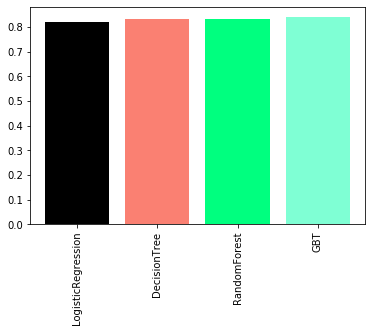

In [41]:
import numpy as np
import matplotlib.pyplot as plt

#Algorithms 
x = ['LogisticRegression', 'DecisionTree', 'RandomForest','GBT'] 

#Accuracy
y = [lr_predict, DT_final_prediction, RF_final_prediction, GBT_final_prediction]

y_pos = np.arange(len(y))
 
# Create bars
plt.bar(y_pos, y)
 
# Create names on the x-axis
plt.xticks(y_pos, x)
 
# Show graphic
plt.bar(y_pos, y, color=['black', 'salmon', 'springgreen', 'aquamarine', 'pink'])
plt.xticks(y_pos, x)
plt.xticks(y_pos, x, rotation='vertical')


plt.show()

# Step 09: Calculate the confusion matrix and find the precision, recall, and F1

In [32]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(confusion_matrix, normalize=False, cmap=plt.cm.Blues):
    
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        font_format = '.2f' 
        print("Normalized confusion matrix")
    else:
        font_format = 'd'
        print('Non-normalization Confusion matrix')

    print(confusion_matrix)
    
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    
    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, format(confusion_matrix[i, j], font_format),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black",
                 size = 24,
                )
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [33]:
def get_matrix(predictions):
    y_true = predictions.select("label")
    y_true = y_true.toPandas()
    y_pred = predictions.select("prediction")
    y_pred = y_pred.toPandas()
    return confusion_matrix(y_true, y_pred)

def get_accuracy(matrix):
    TP = matrix[0][0]
    FP = matrix[1][0]
    FN = matrix[0][1]
    TN = matrix[1][1]    
    precision = (TP + TN) / (TP + TN + FP + FN)
    return precision


def get_precision(matrix):
    TP = matrix[0][0]
    FP = matrix[1][0]
    precision = TP / (TP + FP)
    return precision
    
def get_recall(matrix):
    TP = matrix[0][0]
    FN = matrix[0][1]
    recall = TP / (TP + FN)
    return recall

def get_f1_score(precision, recall):
    f1_score = 2 / ((1 / precision) + (1 / recall))
    return f1_score

In [34]:
def show_matrix(matrix):
    accuracy = get_accuracy(matrix)
    precision = get_precision(matrix)
    recall = get_recall(matrix)
    f1_score = get_f1_score(precision, recall)
    print('Accuracy: %.2f' % accuracy)
    print('Precision: %.2f' % precision)
    print('Recall: %.2f' % recall)
    print('F1 Score: %.2f' % f1_score)
    plot_confusion_matrix(matrix)
    plot_confusion_matrix(matrix, normalize=True)

In [35]:
# Step 09: Calculate the confusion matrix and find the precision, recall, and F1
# score of each classification algorithm. Explain how the accuracy of the
# predication can be improved? 

In [36]:
prediction_list

[DataFrame[features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double],
 DataFrame[features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double],
 DataFrame[features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double],
 DataFrame[features: vector, label: double, rawPrediction: vector, probability: vector, prediction: double]]

## Logistic Regression

Accuracy: 0.83
Precision: 0.85
Recall: 0.95
F1 Score: 0.90
Non-normalization Confusion matrix
[[31265  1729]
 [ 5382  4344]]


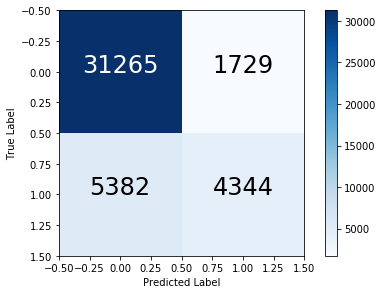

Normalized confusion matrix
[[0.94759653 0.05240347]
 [0.55336212 0.44663788]]


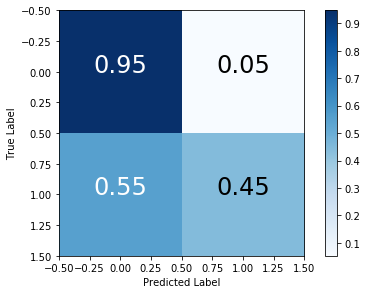

In [37]:
matrix = get_matrix(prediction_list[0])
show_matrix(matrix)

## Decision Tree

Accuracy: 0.83
Precision: 0.85
Recall: 0.96
F1 Score: 0.90
Non-normalization Confusion matrix
[[31576  1418]
 [ 5765  3961]]


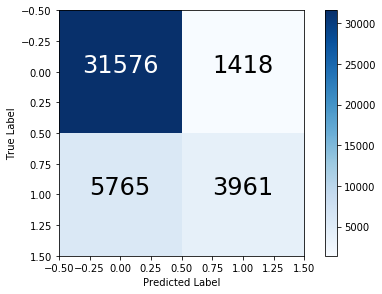

Normalized confusion matrix
[[0.95702249 0.04297751]
 [0.59274111 0.40725889]]


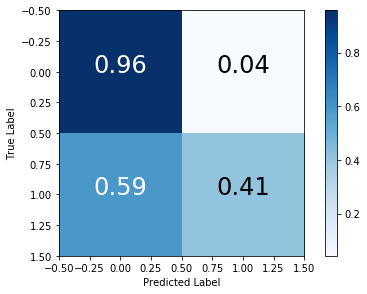

In [38]:
matrix = get_matrix(prediction_list[1])
show_matrix(matrix)

## Random Forest

Accuracy: 0.83
Precision: 0.84
Recall: 0.97
F1 Score: 0.90
Non-normalization Confusion matrix
[[31979  1015]
 [ 6198  3528]]


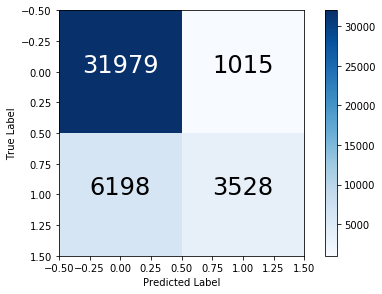

Normalized confusion matrix
[[0.96923683 0.03076317]
 [0.63726095 0.36273905]]


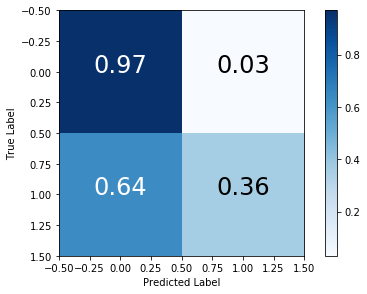

In [39]:
matrix = get_matrix(prediction_list[2])
show_matrix(matrix)

## GBT

Accuracy: 0.84
Precision: 0.86
Recall: 0.95
F1 Score: 0.90
Non-normalization Confusion matrix
[[31341  1653]
 [ 5191  4535]]


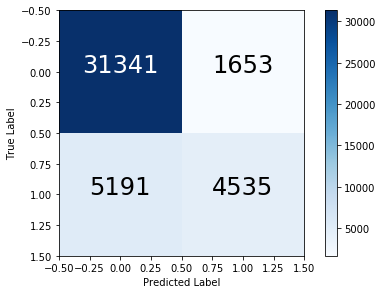

Normalized confusion matrix
[[0.94989998 0.05010002]
 [0.53372404 0.46627596]]


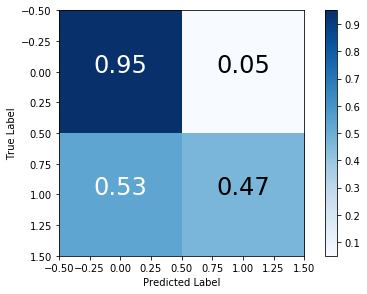

In [40]:
matrix = get_matrix(prediction_list[3])
show_matrix(matrix)

## How to improve performance?
* Improve Performance with Data.
    * Add more Data
    * Clean the data
        * Outliers 
        * Missing Value
    * Data Resample
        * Cross Validation
    * Feature Engineering
        * Data Normalization
        * Data Regulation
    * Feature Selection
        * Select features with domain knowledge
        * Select features with data visualization
* Improve Performance with Algorithms.
    * Try different algorithms like deep learning.
* Improve Performance with Algorithm Tuning.
    * Tune the parameters
* Improve Performance with Ensembles.
    * Bagging
    * Boosting